# Machine learning
## Chapter 8, MNIST FCN classification
## Jun Sup Shin, Digital Imaging, GSAIM, CAU

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image # for renderling image

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

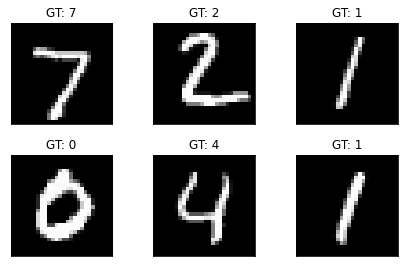

In [2]:
batch_size = 60
epoches = 5

# Compose multiple transformation to one(by using list)
transform=transforms.Compose([
    transforms.ToTensor(), # convert image to torch tensor
    # nomalize by          mean,     std.dev
    transforms.Normalize((0.1307,), (0.3081,))
])

# load dataset                  root      is_train_set
train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, transform=transform)

# utility class to iterate over datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# [batch_size, channel, height, width]
# print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f'GT: {example_targets[i]}')
    plt.xticks([])
    plt.yticks([])
fig.show()

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # size notation : (C, H, W)

        # input, output, kernel size, stride
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # drop out ratio
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # input and output size
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
train_loss = []
test_losses = []

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print(f'Test : Average loss = {test_loss:.4f}, Accuracy:{correct}/{len(test_loader.dataset)} ({100.0 * correct/len(test_loader.dataset)}%)\n')
    

In [5]:
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, epoches+1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000] Loss: 2.2962522506713867
Train Epoch: 1 [6000/60000] Loss: 1.582201361656189
Train Epoch: 1 [12000/60000] Loss: 0.9055836796760559
Train Epoch: 1 [18000/60000] Loss: 0.7177579402923584
Train Epoch: 1 [24000/60000] Loss: 0.5869531631469727
Train Epoch: 1 [30000/60000] Loss: 0.41227561235427856
Train Epoch: 1 [36000/60000] Loss: 0.5858990550041199
Train Epoch: 1 [42000/60000] Loss: 0.5364564061164856
Train Epoch: 1 [48000/60000] Loss: 0.3558119535446167
Train Epoch: 1 [54000/60000] Loss: 0.5276125073432922
Test : Average loss = 0.2883, Accuracy:9173/10000 (91.73%)

Train Epoch: 2 [0/60000] Loss: 0.465760737657547
Train Epoch: 2 [6000/60000] Loss: 0.1538131982088089
Train Epoch: 2 [12000/60000] Loss: 0.29580384492874146
Train Epoch: 2 [18000/60000] Loss: 0.3238401412963867
Train Epoch: 2 [24000/60000] Loss: 0.3145386278629303
Train Epoch: 2 [30000/60000] Loss: 0.2894248962402344
Train Epoch: 2 [36000/60000] Loss: 0.4435342848300934
Train Epoch: 2 [42000/60000] Los

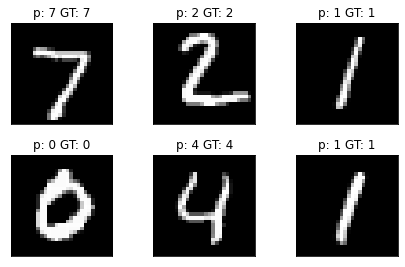

In [6]:
with torch.no_grad():
    output = model(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"p: {output.data.max(1, keepdim=True)[1][i].item()} GT: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
fig.show()

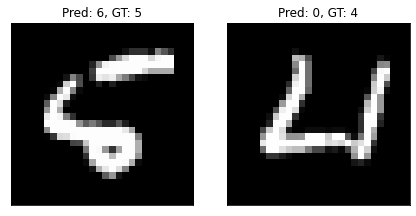

In [7]:
wrong_idx = []

for i in range(len(example_data)):
    if output.data.max(1, keepdim=True)[1][i].item() != example_targets[i]:
        wrong_idx.append(i)

fig = plt.figure()
for i in range(len(wrong_idx)):
    plt.subplot(1, len(wrong_idx), i+1)
    plt.tight_layout()
    plt.imshow(example_data[wrong_idx[i]][0], cmap='gray', interpolation='none')
    plt.title(f"Pred: {output.data.max(1, keepdim=True)[1][wrong_idx[i]].item()}, GT: {example_targets[wrong_idx[i]]}")
    plt.xticks([])
    plt.yticks([])
fig.show()